# **Introduccion**

# **CNN**

In [1]:
# Se carga drive para cargar el dataset posteriormente
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Iniciamos importando las librerias y modulos necesarios.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import os.path
import torch
import torchvision
import tarfile
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [7]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
dataset = ImageFolder('/content/drive/MyDrive/Colab Notebooks/tarea4IA/iris', transform=transformer)

In [8]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  iris-setosa (0)


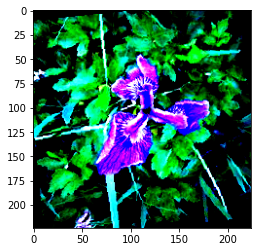

In [9]:
show_example(*dataset[1])

In [10]:
validation_size = 500
training_size = len(dataset) - validation_size

In [11]:
dataset.classes

['iris-setosa', 'iris-versicolour', 'iris-virginica']

In [12]:
train_ds, val_ds = random_split(dataset,[training_size, validation_size])
len(train_ds), len(val_ds)
img, label = train_ds[0]
img.shape

torch.Size([3, 224, 224])

Label:  iris-versicolour (1)


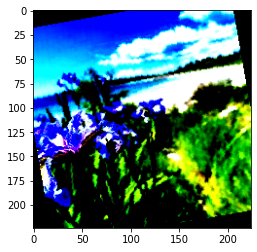

In [13]:
show_example(*train_ds[1])

In [14]:
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 32)

In [15]:
print(dataset.classes)

['iris-setosa', 'iris-versicolour', 'iris-virginica']


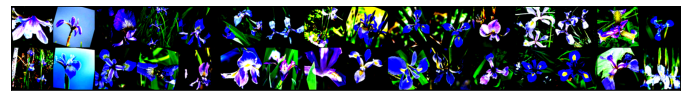

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
model = ImageClassificationModel()
model

ImageClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Lin

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([-0.0473, -0.0099,  0.0010,  0.0572,  0.0469],
       grad_fn=<SelectBackward0>)


In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [24]:
model = to_device(ImageClassificationModel(), device)
evaluate(model, val_dl)

{'val_loss': 1.6184275150299072, 'val_acc': 0.22430555522441864}

In [25]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [26]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3560, val_loss: 0.9819, val_acc: 0.6153
Epoch [1], train_loss: 0.9644, val_loss: 0.9440, val_acc: 0.6153
Epoch [2], train_loss: 0.9198, val_loss: 0.9512, val_acc: 0.6153


In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

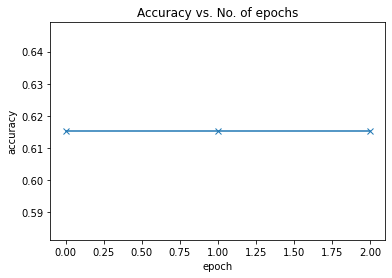

In [28]:
plot_accuracies(history)

# **Parte 2**


In [3]:
import numpy as np 
import pandas as pd
import time 
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import io
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tarea4IA/Iris.csv")
image_dir = Path('/content/drive/MyDrive/Colab Notebooks/tarea4IA/iris')

In [5]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)

In [6]:
path_setosa = pd.Series(list(image_dir.glob(r'iris-setosa/*.jpg')), name='file').astype(str)
path_versicolour = pd.Series(list(image_dir.glob(r'iris-versicolour/*.jpg')), name='file').astype(str)
path_verginica = pd.Series(list(image_dir.glob(r'iris-virginica/*.jpg')), name='file').astype(str)

In [7]:
for i in range(150):
  if i<50:
    df.loc[i, 'image'] = path_setosa[i]
  elif 50<=i<100:
    df.loc[i, 'image'] = path_versicolour[i-50]
  else:
    df.loc[i, 'image'] = path_verginica[i-100]

In [8]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,image
0,1,5.1,3.5,1.4,0.2,Iris-setosa,/content/drive/MyDrive/Colab Notebooks/tarea4I...
1,2,4.9,3.0,1.4,0.2,Iris-setosa,/content/drive/MyDrive/Colab Notebooks/tarea4I...
2,3,4.7,3.2,1.3,0.2,Iris-setosa,/content/drive/MyDrive/Colab Notebooks/tarea4I...
3,4,4.6,3.1,1.5,0.2,Iris-setosa,/content/drive/MyDrive/Colab Notebooks/tarea4I...
4,5,5.0,3.6,1.4,0.2,Iris-setosa,/content/drive/MyDrive/Colab Notebooks/tarea4I...
...,...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica,/content/drive/MyDrive/Colab Notebooks/tarea4I...
146,147,6.3,2.5,5.0,1.9,Iris-virginica,/content/drive/MyDrive/Colab Notebooks/tarea4I...
147,148,6.5,3.0,5.2,2.0,Iris-virginica,/content/drive/MyDrive/Colab Notebooks/tarea4I...
148,149,6.2,3.4,5.4,2.3,Iris-virginica,/content/drive/MyDrive/Colab Notebooks/tarea4I...


In [22]:
transformer = transforms.Compose(
    [   transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor()
    ]
)

dataset = ImageFolder('/content/drive/MyDrive/Colab Notebooks/tarea4IA/iris', transform=transformer)

# Cálculo de mean y std del dataset. Ejecutar solo para comprobar el valor obtenido más abajo
image_data_loader = DataLoader(
     dataset,
     batch_size=len(dataset),
     shuffle=False,
     num_workers=0)
def mean_std(loader):
   images, lebels = next(iter(loader))
   mean, std = images.mean([0,2,3]), images.std([0,2,3])
   return mean, std
mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.3364, 0.3795, 0.2884]) tensor([0.2373, 0.2356, 0.2920])


In [10]:
transformer_norm = transforms.Compose(
    [   transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.3659, 0.4167, 0.3086],
                         std= [0.2212, 0.2119, 0.2871])
    ]
)

dataset = ImageFolder('/content/drive/MyDrive/Colab Notebooks/tarea4IA/iris', transform=transformer_norm)


numTrainSamples = int(len(dataset) * 0.8) #cantidad de training
numValSamples = int(len(dataset) * 0.1) #cantidad de validacion 
numTestSamples = len(dataset) - numTrainSamples - numValSamples #cantidad de testing

data_train, data_validation, data_test = random_split(dataset, [numTrainSamples, numValSamples, numTestSamples], generator=torch.Generator().manual_seed(42))

print('Largos de los conjuntos disjuntos del dataset: ')
print('data_train:', len(data_train))
print('data_validation:', len(data_validation))
print('data_test:', len(data_test))

print(data_train.dataset.classes)

BATCH_SIZE = 64

trainDataLoader = DataLoader(data_train, shuffle=True,	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(data_validation, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(data_test, batch_size=BATCH_SIZE)

Largos de los conjuntos disjuntos del dataset: 
data_train: 336
data_validation: 42
data_test: 43
['iris-setosa', 'iris-versicolour', 'iris-virginica']


In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch+1, result)
        history.append(result)
    return history

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
model = ImageClassificationModel()
trainDataLoader = DeviceDataLoader(trainDataLoader, device)
valDataLoader = DeviceDataLoader(valDataLoader, device)
to_device(model, device)

ImageClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Lin

In [31]:
model = to_device(ImageClassificationModel(), device)
evaluate(model, valDataLoader)

{'val_loss': 1.100716471672058, 'val_acc': 0.2380952388048172}

In [15]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0003

In [16]:
print("[INFO] training the network...")
startTime = time.time()

history = fit(num_epochs, lr, model, trainDataLoader, valDataLoader, opt_func)

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

Se truncaron las últimas líneas 5000 del resultado de transmisión.
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542],
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542]],

         [[-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          ...,
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665]],

         [[-1.0749, -1.0749, -1.0749,  ..., -1.0749, -1.0749, -1.0749],
          [-1.0749, -1.0749, -1.0749,  ..., -1.0749, -1.0749, -1.0749],
          [-1.0749, -1.0749, -1.0749,  ..., -1.0749, -1.0749, -1.0749],
          ...,
          [-1.0749, -1.0749, -1.0749,  ..., -1.0749, -1.0749, -1.0749],
          [-1.0749, -1.0749, -1.074

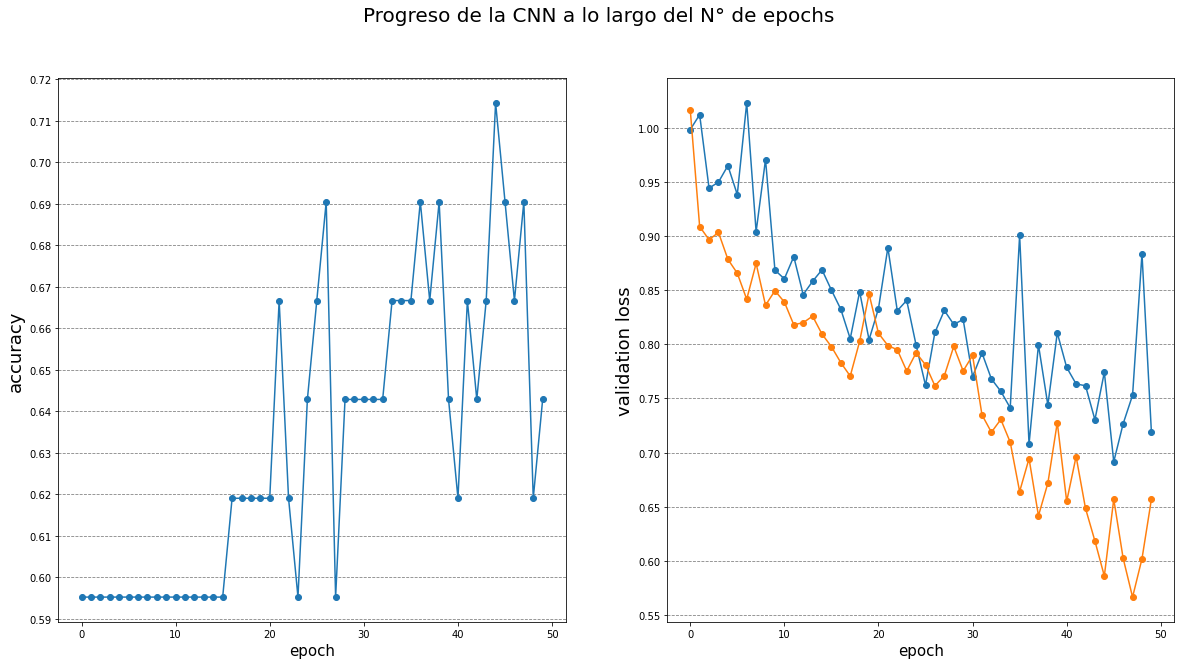

In [17]:
def plot_accuracies(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
  accuracies = [x['val_acc'] for x in history]
  val_loss = [x['val_loss'] for x in history]
  train_loss = [x['train_loss'] for x in history]
  ax1.plot(accuracies, '-o')
  ax2.plot(val_loss, '-o')
  ax2.plot(train_loss, '-o')
  fig.set_figwidth(20)
  fig.set_figheight(10)
  ax1.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
  ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
  ax2.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
  ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
  ax1.set_xlabel('epoch', fontsize=15)
  ax2.set_xlabel('epoch', fontsize=15)
  ax1.set_ylabel('accuracy', fontsize=18)
  ax2.set_ylabel('validation loss', fontsize=18)
  fig.suptitle('Progreso de la CNN a lo largo del N° de epochs', fontsize=20);

plot_accuracies(history)

In [18]:
testDataLoader = DeviceDataLoader(testDataLoader, device)
evaluate(model, testDataLoader)

[tensor([[[[-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542],
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542],
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542],
          ...,
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542],
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542],
          [-1.6542, -1.6542, -1.6542,  ..., -1.6542, -1.6542, -1.6542]],

         [[-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          ...,
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665],
          [-1.9665, -1.9665, -1.9665,  ..., -1.9665, -1.9665, -1.9665]],

         [[-1.0749, -1.0749, -1.0749,  ..., -1.0749, -1.0749, -1.0749],
          [-1.0749, -1.0749, 

{'val_loss': 0.870000958442688, 'val_acc': 0.5813953280448914}

Label: iris-virginica , Predicted: iris-versicolour


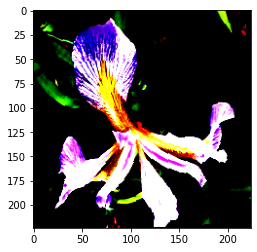

In [19]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = data_test[12]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# **GMM y DBSCAN** 

Para esta parte, usaremos la misma proporción utilizada anteriormente, pero ahora usaremos solamente la columna "V1" y "Amount". Con esto logramos observar graficamente GMM y DBSCAN

In [ ]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import missingno as mno
import seaborn as sns
#Modelo
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#Error
from sklearn.metrics import mean_squared_error

Ahora, calculamos la cantidad de componentes o clusters a usar en el modelo GMM. Para esto buscaremos el menor 'Bayesian Information Criterion' (BIC), el cual es un criterio que indica que tan bien se  ajustan los datos al modelo dado un número de clusters, de modo que mientras más bajo, más preciso.

In [ ]:
Z = df[['V4', 'V9']].values
Z_train, Z_test = train_test_split(Z, train_size=0.8, random_state=1)

In [ ]:
n_clusters = range(25,55) #El rango fue reducido puesto que en una primera ejecución calculamos del 1 al 100, y ya conociendo el valor ideal es que redujimos a 25-55
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Z_train) for n in tqdm(n_clusters)]


100%|██████████| 30/30 [02:26<00:00,  4.88s/it]


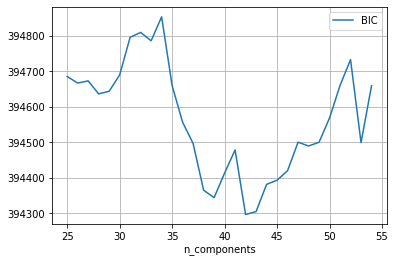

  0%|          | 0/30 [00:24<?, ?it/s]


In [ ]:
plt.plot(n_clusters, [m.bic(Z_train) for m in models], label='BIC')
#plt.plot(n_clusters, [m.aic(Z_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.grid()

Concluimos que la mejor cantidad de componentes es de 42.

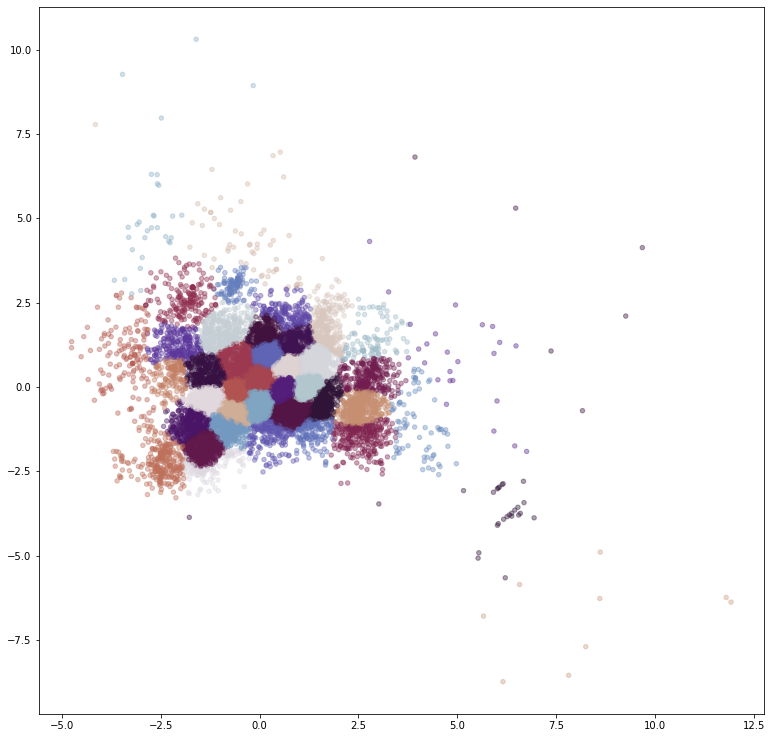

In [ ]:
gm = GaussianMixture(42, covariance_type='full', random_state=0).fit(Z_train)
y_prediction_gm = gm.predict(Z_test)
fig, ax = plt.subplots()
fig.set_figwidth(13)
fig.set_figheight(13)
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_prediction_gm, s=20, alpha=0.4, cmap='twilight_shifted');

Ahora, calculamos el epsilon para esto graficamos los n-vecinos más cercanos en base al algoritmo NN, con este encontramos la relación entre la distancia (epsilon) y la cantidad de puntos que logra abarcar.

Text(0, 0.5, 'Distance')

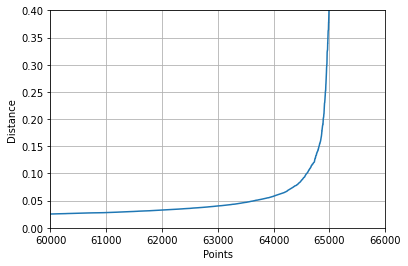

In [ ]:
k = 2

# Calculate NN
neighbors = NearestNeighbors(n_neighbors=k).fit(Z_train)
distances, indices = neighbors.kneighbors(Z_train)
distances = np.sort(distances, axis=0)

# Get distances
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i, 
    y = distances

)
plt.axis([60000, 66000, 0, 0.4])
plt.grid()
plt.xlabel("Points")
plt.ylabel("Distance")

Con esto concluimos que un buen número para el epsilon es 0.075 y dejaremos la cantidad de vecinos default. (5)

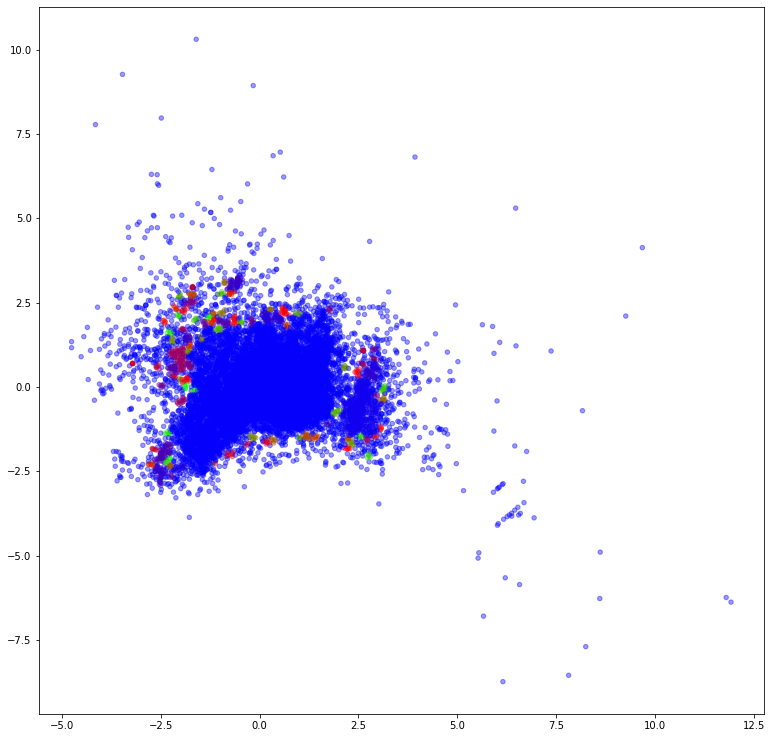

In [ ]:
clustering = DBSCAN(eps=0.075).fit_predict(Z_test)
fig, ax = plt.subplots()
fig.set_figwidth(13)
fig.set_figheight(13)
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=clustering, s=20, alpha=0.4, cmap='brg')

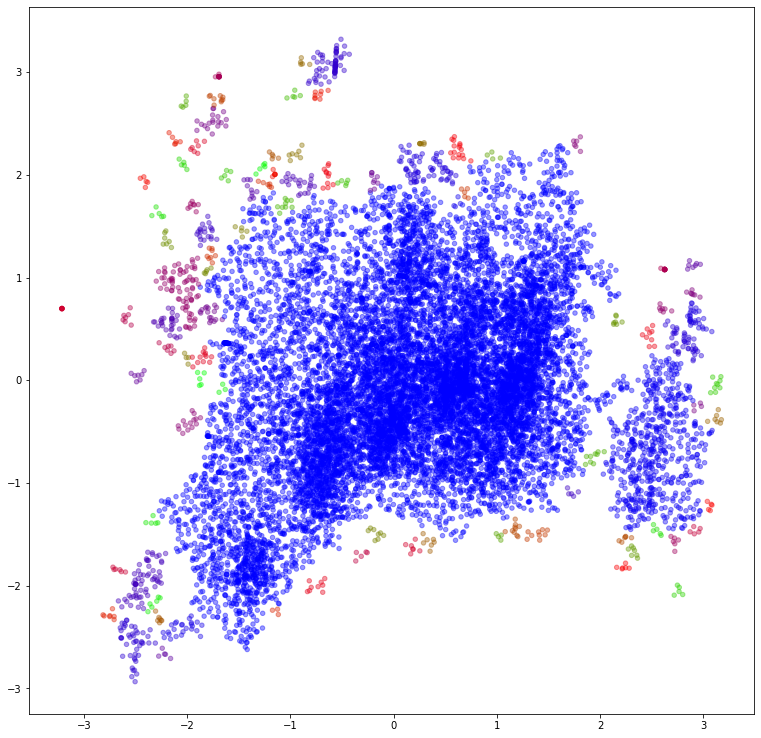

In [ ]:
dbscan = DBSCAN(eps=0.075).fit_predict(Z_test)
labels = dbscan[0]
count = 0
index = 0

for i in range(len(dbscan)):
  if i != 0:
    if dbscan[i] != -1:
      labels = np.append(labels, dbscan[i])
      index = np.append(index, i) 

Z_test_plot = np.zeros((len(labels),2))
for i in range(len(labels)):
  Z_test_plot[i] = Z_test[index[i]]
fig, ax = plt.subplots()
fig.set_figwidth(13)
fig.set_figheight(13)
plt.scatter(Z_test_plot[:, 0], Z_test_plot[:, 1], c=labels, s=20, alpha=0.4, cmap='brg')

In [ ]:
n_clusters_ = len(set(clustering)) - (1 if -1 in clustering else 0)
n_noise_ = list(clustering).count(-1)
print('Cantidad de Clusters:', n_clusters_)
print('Cantidad de outlier:', n_noise_)

Cantidad de Clusters: 92
Cantidad de outlier: 1535


Se puede ver que ambos algoritmos son de clustering, en el sentido de que ambos generan clusters de puntos, sin embargo podemos diferenciar que GMM genera los clusters según la cantidad definida por nosotros, mientras que DBSCAN genera los clusters en función del epsilon. Además, GMM nos da información como la cantidad de clusters o sub-grupos que comparten relación, mientras que DBSCAN nos da información sobre la cantidad de outliers y sobre que tan densos son nuestros clusters.

Ahora, al observar el grafico observamos la principal diferencia entre DBSCAN y GMM, donde DBSCAN nos muestra la densidad que existe en los clusters, teniendo un gran cluster extremadamente denso y otros cluster más pequeños, mientras que GMM nos genera pequeños clusters con una cantidad casi homogenea de estos.